# Introduction

This notebook will be used only to analyze data from the SciPy execution of Leaflet Finder. The experiment setup is as follows:

1. Execution was done on Comet.
2. The core count was 64,256,1024 cores
3. One CU/task per core
4. The calculation was done over 131072,262144 and 524288 atoms
5. Each task is responsible to calculate the connected components of the subgraph it sees.
6. Finally all, sub connected components are aggregated in a final one

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))

In [2]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [3]:
def SparkLogToDataFrame(path,filename):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','ExecutorID','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','GettingResultTime','ResultSerializationTime','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

      
        
        
    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,11),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Executor ID'])
            data_point[0,3] = int(stat['Task Info']['Launch Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,6] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])-int(stat['Task Info']['Getting Result Time']) if int(stat['Task Info']['Getting Result Time'])!=0 else 0 
            data_point[0,8] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,9] = int(stat['Task Info']['Finish Time'])
            data_point[0,10] = int(stat['Task Metrics']['Result Size'])
            
            data_point[0,4]= data_point[0,9]-data_point[0,3]-data_point[0,5]-data_point[0,6]-data_point[0,8]-data_point[0,7]
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [4]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/' + appName
        print appPath
        timings = np.load(path + sessionName + '/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [5]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

# Spark Experiments

In [6]:
spParCC_lf = pandas.DataFrame.from_csv('Spark/Scipy-par-CC/spParCCweakscaling.csv')

spParCC_lf

tidy_weak = pandas.melt(spParCC_lf.drop(['SessionName','JsonName'],axis=1),id_vars=['Cores','Try','Atoms','Partition'],var_name='Type', value_name='Time(s)')
tidy_weak.to_csv('lfrp_sparkParCC_comet_weakScaling.csv')

In [7]:
spParCC_lf_ParCC_app_131K_64_1 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][0]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][0])
spParCC_lf_ParCC_app_131K_64_2 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][1]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][1])
spParCC_lf_ParCC_app_131K_64_3 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][2]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][2])
spParCC_lf_ParCC_app_131K_64_4 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][3]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][3])
spParCC_lf_ParCC_app_131K_64_5 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][4]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][4])
spParCC_lf_ParCC_app_262K_256_1 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][5]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][5])
spParCC_lf_ParCC_app_262K_256_2 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][6]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][6])
spParCC_lf_ParCC_app_262K_256_3 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][7]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][7])
spParCC_lf_ParCC_app_262K_256_4 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][8]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][8])
spParCC_lf_ParCC_app_262K_256_5 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][9]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][9])
spParCC_lf_ParCC_app_524K_1024_1 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][10]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][10])
spParCC_lf_ParCC_app_524K_1024_2 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][11]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][11])
spParCC_lf_ParCC_app_524K_1024_3 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][12]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][12])
spParCC_lf_ParCC_app_524K_1024_4 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][13]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][13])
spParCC_lf_ParCC_app_524K_1024_5 = SparkLogToDataFrame('Spark/AppData/spParCCweak/'+spParCC_lf['SessionName'][14]+'-pilot.0000/unit.000000/',spParCC_lf['JsonName'][14])


# Plotting

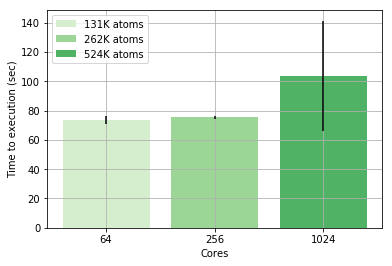

In [13]:
width=0.5
sp_ParCC_lf_weak=pandas.DataFrame(columns=['Pilot-Spark Exec with ParCC'])
adjmatrx = spParCC_lf['Execution'][0:5].mean()
sp_ParCC_lf_weak.loc[0] = [adjmatrx]

adjmatrx = spParCC_lf['Execution'][5:10].mean()
sp_ParCC_lf_weak.loc[1] = [adjmatrx]

adjmatrx = spParCC_lf['Execution'][10:15].mean()
sp_ParCC_lf_weak.loc[2] = [adjmatrx]

x=np.arange(3)
plt.bar(x[0],spParCC_lf['Execution'][0:5].mean(),yerr=spParCC_lf['Execution'][0:5].std(),width=0.8,label='131K atoms',color=greens(50))
plt.bar(x[1],spParCC_lf['Execution'][5:10].mean(),yerr=spParCC_lf['Execution'][5:10].std(),width=0.8,label='262K atoms',color=greens(100))
plt.bar(x[2],spParCC_lf['Execution'][10:15].mean(),yerr=spParCC_lf['Execution'][10:15].std(),width=0.8,label='524K atoms',color=greens(150))
plt.legend(loc='upper left')
plt.xticks(x,('64','256','1024'))
plt.xlabel('Cores')
plt.grid()
plt.ylabel('Time to execution (sec)')
plt.savefig('lfrp_sparkParcc_comet_weakScaling2.png',dpi=800,bbox_inches='tight')
plt.savefig('lfrp_sparkParCC_comet_weakScaling2.pdf',dpi=800,bbox_inches='tight')
#sp_ParCC_lf_weak.plot(kind='bar',legend=True,colormap='Paired')

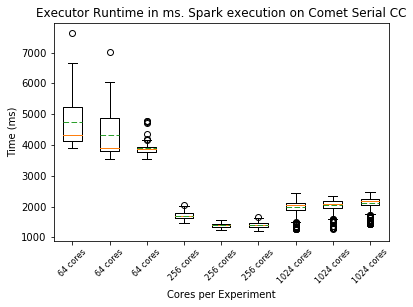

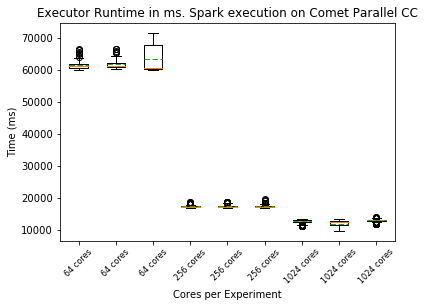

In [234]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spsc_lf_app_64_1['Runtime'][64:],\
             spsc_lf_app_64_2['Runtime'][64:],\
             spsc_lf_app_64_3['Runtime'][64:],\
             spsc_lf_app_256_1['Runtime'][256:],\
             spsc_lf_app_256_2['Runtime'][256:],\
             spsc_lf_app_256_3['Runtime'][256:],\
             spsc_lf_app_1024_1['Runtime'][1024:],\
             spsc_lf_app_1024_2['Runtime'][1024:],\
             spsc_lf_app_1024_3['Runtime'][1024:]], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Executor Runtime in ms. Spark execution on Comet Serial CC')
plt.savefig('RuntimeSerialCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('RuntimeSerialCC.png',dpi=800,bbox_inches='tight')

fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['Runtime'],\
                  spParCC_lf_ParCC_app_64_2['Runtime'],\
                  spParCC_lf_ParCC_app_64_3['Runtime'],\
                  spParCC_lf_ParCC_app_256_1['Runtime'],\
                  spParCC_lf_ParCC_app_256_2['Runtime'],\
                  spParCC_lf_ParCC_app_256_3['Runtime'],\
                  spParCC_lf_ParCC_app_1024_1['Runtime'],\
                  spParCC_lf_ParCC_app_1024_2['Runtime'],\
                  spParCC_lf_ParCC_app_1024_3['Runtime']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Executor Runtime in ms. Spark execution on Comet Parallel CC')
plt.savefig('RuntimeParallelCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('RuntimeParallelCC.png',dpi=800,bbox_inches='tight')

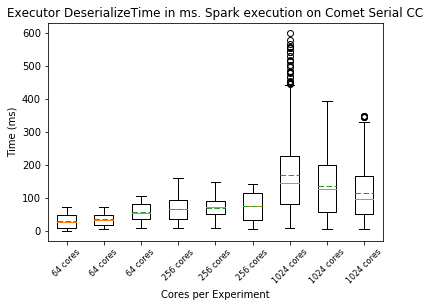

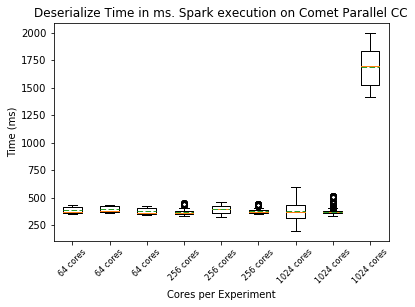

In [18]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spsc_lf_app_64_1['DeserializeTime'][64:],\
             spsc_lf_app_64_2['DeserializeTime'][64:],\
             spsc_lf_app_64_3['DeserializeTime'][64:],\
             spsc_lf_app_256_1['DeserializeTime'][256:],\
             spsc_lf_app_256_2['DeserializeTime'][256:],\
             spsc_lf_app_256_3['DeserializeTime'][256:],\
             spsc_lf_app_1024_1['DeserializeTime'][1024:],\
             spsc_lf_app_1024_2['DeserializeTime'][1024:],\
             spsc_lf_app_1024_3['DeserializeTime'][1024:]], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Executor DeserializeTime in ms. Spark execution on Comet Serial CC')
plt.savefig('DeserializeTimeSerialCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('DeserializeTimeSerialCC.png',dpi=800,bbox_inches='tight')

fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['DeserializeTime'],\
                  spParCC_lf_ParCC_app_64_2['DeserializeTime'],\
                  spParCC_lf_ParCC_app_64_3['DeserializeTime'],\
                  spParCC_lf_ParCC_app_256_1['DeserializeTime'],\
                  spParCC_lf_ParCC_app_256_2['DeserializeTime'],\
                  spParCC_lf_ParCC_app_256_3['DeserializeTime'],\
                  spParCC_lf_ParCC_app_1024_1['DeserializeTime'],\
                  spParCC_lf_ParCC_app_1024_2['DeserializeTime'],\
                  spParCC_lf_ParCC_app_1024_3['DeserializeTime']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Deserialize Time in ms. Spark execution on Comet Parallel CC')
plt.savefig('DeserializeTimeParallelCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('DeserializeTimeParallelCC.png',dpi=800,bbox_inches='tight')

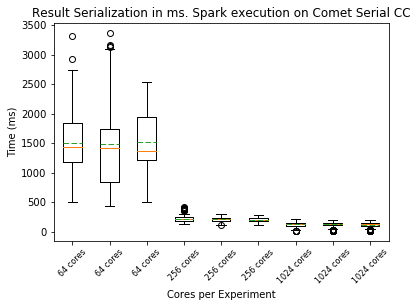

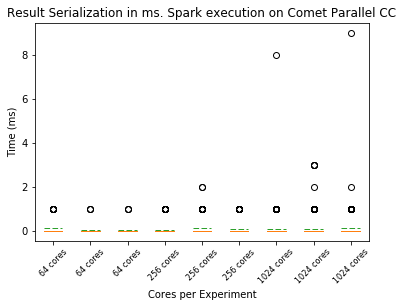

In [233]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spsc_lf_app_64_1['ResultSerializationTime'][64:],\
             spsc_lf_app_64_2['ResultSerializationTime'][64:],\
             spsc_lf_app_64_3['ResultSerializationTime'][64:],\
             spsc_lf_app_256_1['ResultSerializationTime'][256:],\
             spsc_lf_app_256_2['ResultSerializationTime'][256:],\
             spsc_lf_app_256_3['ResultSerializationTime'][256:],\
             spsc_lf_app_1024_1['ResultSerializationTime'][1024:],\
             spsc_lf_app_1024_2['ResultSerializationTime'][1024:],\
             spsc_lf_app_1024_3['ResultSerializationTime'][1024:]], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Result Serialization in ms. Spark execution on Comet Serial CC')
plt.savefig('ResultSerializationTimeSerialCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('ResultSerializationTimeSerialCC.png',dpi=800,bbox_inches='tight')


fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_64_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_64_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_256_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_256_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_256_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_1024_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_1024_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_1024_3['ResultSerializationTime']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Result Serialization in ms. Spark execution on Comet Parallel CC')
plt.savefig('ResultSerializationTimeParallelCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('ResultSerializationTimeParallelCC.png',dpi=800,bbox_inches='tight')

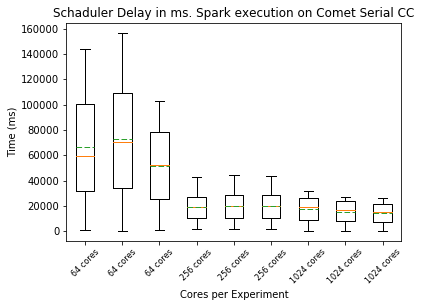

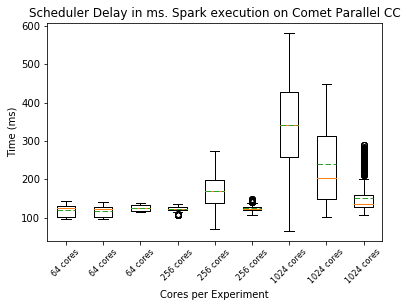

In [232]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spsc_lf_app_64_1['SchedulerDelay'][64:],\
             spsc_lf_app_64_2['SchedulerDelay'][64:],\
             spsc_lf_app_64_3['SchedulerDelay'][64:],\
             spsc_lf_app_256_1['SchedulerDelay'][256:],\
             spsc_lf_app_256_2['SchedulerDelay'][256:],\
             spsc_lf_app_256_3['SchedulerDelay'][256:],\
             spsc_lf_app_1024_1['SchedulerDelay'][1024:],\
             spsc_lf_app_1024_2['SchedulerDelay'][1024:],\
             spsc_lf_app_1024_3['SchedulerDelay'][1024:]], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Schaduler Delay in ms. Spark execution on Comet Serial CC')
plt.savefig('SchedulerDelaySerialCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('SchedulerDelaySerialCC.png',dpi=800,bbox_inches='tight')

fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_64_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_64_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_256_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_256_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_256_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_1024_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_1024_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_1024_3['SchedulerDelay']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Scheduler Delay in ms. Spark execution on Comet Parallel CC')
plt.savefig('SchedulerDelayParallelCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('SchedulerDelayParallelCC.png',dpi=800,bbox_inches='tight')

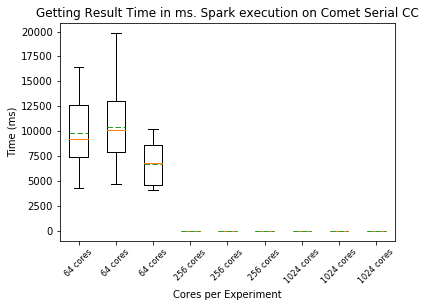

In [231]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spsc_lf_app_64_1['GettingResultTime'][64:],\
             spsc_lf_app_64_2['GettingResultTime'][64:],\
             spsc_lf_app_64_3['GettingResultTime'][64:],\
             spsc_lf_app_256_1['GettingResultTime'][256:],\
             spsc_lf_app_256_2['GettingResultTime'][256:],\
             spsc_lf_app_256_3['GettingResultTime'][256:],\
             spsc_lf_app_1024_1['GettingResultTime'][1024:],\
             spsc_lf_app_1024_2['GettingResultTime'][1024:],\
             spsc_lf_app_1024_3['GettingResultTime'][1024:]], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Getting Result Time in ms. Spark execution on Comet Serial CC')
plt.savefig('gettingResultSerialCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('gettingResultSerialCC.png',dpi=800,bbox_inches='tight')

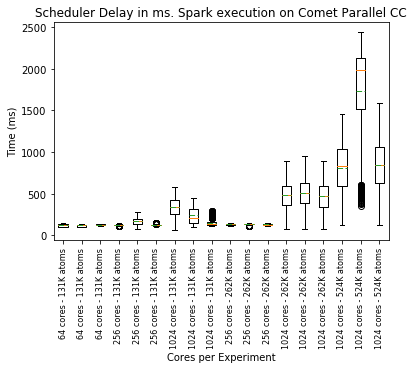

In [244]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_64_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_64_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_256_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_256_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_256_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_1024_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_1024_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_1024_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_262K_256_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_262K_256_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_262K_256_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_262K_1024_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_262K_1024_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_262K_1024_3['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_524K_1024_1['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_524K_1024_2['SchedulerDelay'],\
                  spParCC_lf_ParCC_app_524K_1024_3['SchedulerDelay']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores - 131K atoms','64 cores - 131K atoms','64 cores - 131K atoms',
             '256 cores - 131K atoms','256 cores - 131K atoms','256 cores - 131K atoms',\
             '1024 cores - 131K atoms','1024 cores - 131K atoms','1024 cores - 131K atoms',\
             '256 cores - 262K atoms','256 cores - 262K atoms','256 cores - 262K atoms',\
             '1024 cores - 262K atoms','1024 cores - 262K atoms','1024 cores - 262K atoms',\
             '1024 cores - 524K atoms','1024 cores - 524K atoms','1024 cores - 524K atoms']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=90, fontsize=8)
plt.title('Scheduler Delay in ms. Spark execution on Comet Parallel CC')
plt.savefig('SchedulerDelayParallelCCallsystems.pdf',dpi=800,bbox_inches='tight')
plt.savefig('SchedulerDelayParallelCCallsystems.png',dpi=800,bbox_inches='tight')

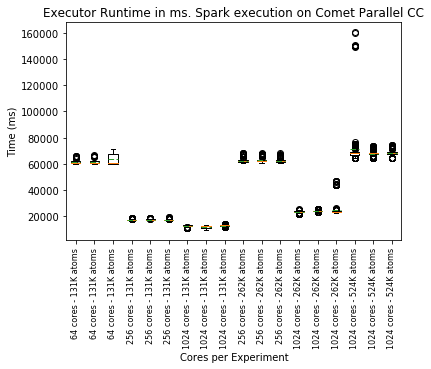

In [248]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['Runtime'],\
                  spParCC_lf_ParCC_app_64_2['Runtime'],\
                  spParCC_lf_ParCC_app_64_3['Runtime'],\
                  spParCC_lf_ParCC_app_256_1['Runtime'],\
                  spParCC_lf_ParCC_app_256_2['Runtime'],\
                  spParCC_lf_ParCC_app_256_3['Runtime'],\
                  spParCC_lf_ParCC_app_1024_1['Runtime'],\
                  spParCC_lf_ParCC_app_1024_2['Runtime'],\
                  spParCC_lf_ParCC_app_1024_3['Runtime'],\
                  spParCC_lf_ParCC_app_262K_256_1['Runtime'],\
                  spParCC_lf_ParCC_app_262K_256_2['Runtime'],\
                  spParCC_lf_ParCC_app_262K_256_3['Runtime'],\
                  spParCC_lf_ParCC_app_262K_1024_1['Runtime'],\
                  spParCC_lf_ParCC_app_262K_1024_2['Runtime'],\
                  spParCC_lf_ParCC_app_262K_1024_3['Runtime'],\
                  spParCC_lf_ParCC_app_524K_1024_1['Runtime'],\
                  spParCC_lf_ParCC_app_524K_1024_2['Runtime'],\
                  spParCC_lf_ParCC_app_524K_1024_3['Runtime']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores - 131K atoms','64 cores - 131K atoms','64 cores - 131K atoms',
             '256 cores - 131K atoms','256 cores - 131K atoms','256 cores - 131K atoms',\
             '1024 cores - 131K atoms','1024 cores - 131K atoms','1024 cores - 131K atoms',\
             '256 cores - 262K atoms','256 cores - 262K atoms','256 cores - 262K atoms',\
             '1024 cores - 262K atoms','1024 cores - 262K atoms','1024 cores - 262K atoms',\
             '1024 cores - 524K atoms','1024 cores - 524K atoms','1024 cores - 524K atoms']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=90, fontsize=8)
plt.title('Executor Runtime in ms. Spark execution on Comet Parallel CC')
plt.savefig('RuntimeParallelCCallsystems.pdf',dpi=800,bbox_inches='tight')
plt.savefig('RuntimeParallelCCallsystems.png',dpi=800,bbox_inches='tight')

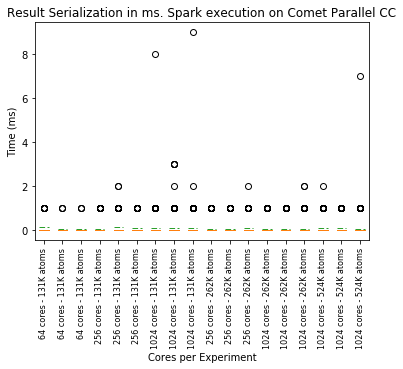

In [245]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_64_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_64_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_256_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_256_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_256_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_1024_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_1024_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_1024_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_262K_256_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_262K_256_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_262K_256_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_262K_1024_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_262K_1024_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_262K_1024_3['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_524K_1024_1['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_524K_1024_2['ResultSerializationTime'],\
                  spParCC_lf_ParCC_app_524K_1024_3['ResultSerializationTime']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Time (ms)')
upperLabels=['64 cores - 131K atoms','64 cores - 131K atoms','64 cores - 131K atoms',
             '256 cores - 131K atoms','256 cores - 131K atoms','256 cores - 131K atoms',\
             '1024 cores - 131K atoms','1024 cores - 131K atoms','1024 cores - 131K atoms',\
             '256 cores - 262K atoms','256 cores - 262K atoms','256 cores - 262K atoms',\
             '1024 cores - 262K atoms','1024 cores - 262K atoms','1024 cores - 262K atoms',\
             '1024 cores - 524K atoms','1024 cores - 524K atoms','1024 cores - 524K atoms']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=90, fontsize=8)
plt.title('Result Serialization in ms. Spark execution on Comet Parallel CC')
plt.savefig('ResultSerializationTimeParallelCCallsystems.pdf',dpi=800,bbox_inches='tight')
plt.savefig('ResultSerializationTimeParallelCCallsystems.png',dpi=800,bbox_inches='tight')

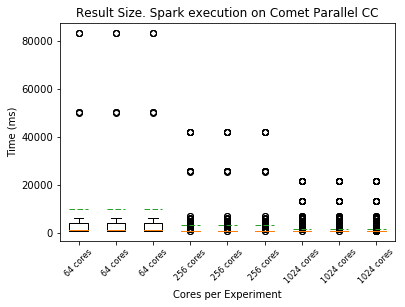

In [19]:
fig,axes = plt.subplots(ncols=1, nrows=1)
ax = plt.boxplot([spParCC_lf_ParCC_app_64_1['ResultSize'],\
                  spParCC_lf_ParCC_app_64_2['ResultSize'],\
                  spParCC_lf_ParCC_app_64_3['ResultSize'],\
                  spParCC_lf_ParCC_app_256_1['ResultSize'],\
                  spParCC_lf_ParCC_app_256_2['ResultSize'],\
                  spParCC_lf_ParCC_app_256_3['ResultSize'],\
                  spParCC_lf_ParCC_app_1024_1['ResultSize'],\
                  spParCC_lf_ParCC_app_1024_2['ResultSize'],\
                  spParCC_lf_ParCC_app_1024_3['ResultSize']], meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
plt.xlabel('Cores per Experiment')
plt.ylabel('Bytes of ')
upperLabels=['64 cores','64 cores','64 cores','256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']

xtickNames = plt.setp(axes, xticklabels=upperLabels)
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.title('Result Size. Spark execution on Comet Parallel CC')
plt.savefig('ResultSizeParallelCC.pdf',dpi=800,bbox_inches='tight')
plt.savefig('ResultSizeParallelCC.png',dpi=800,bbox_inches='tight')

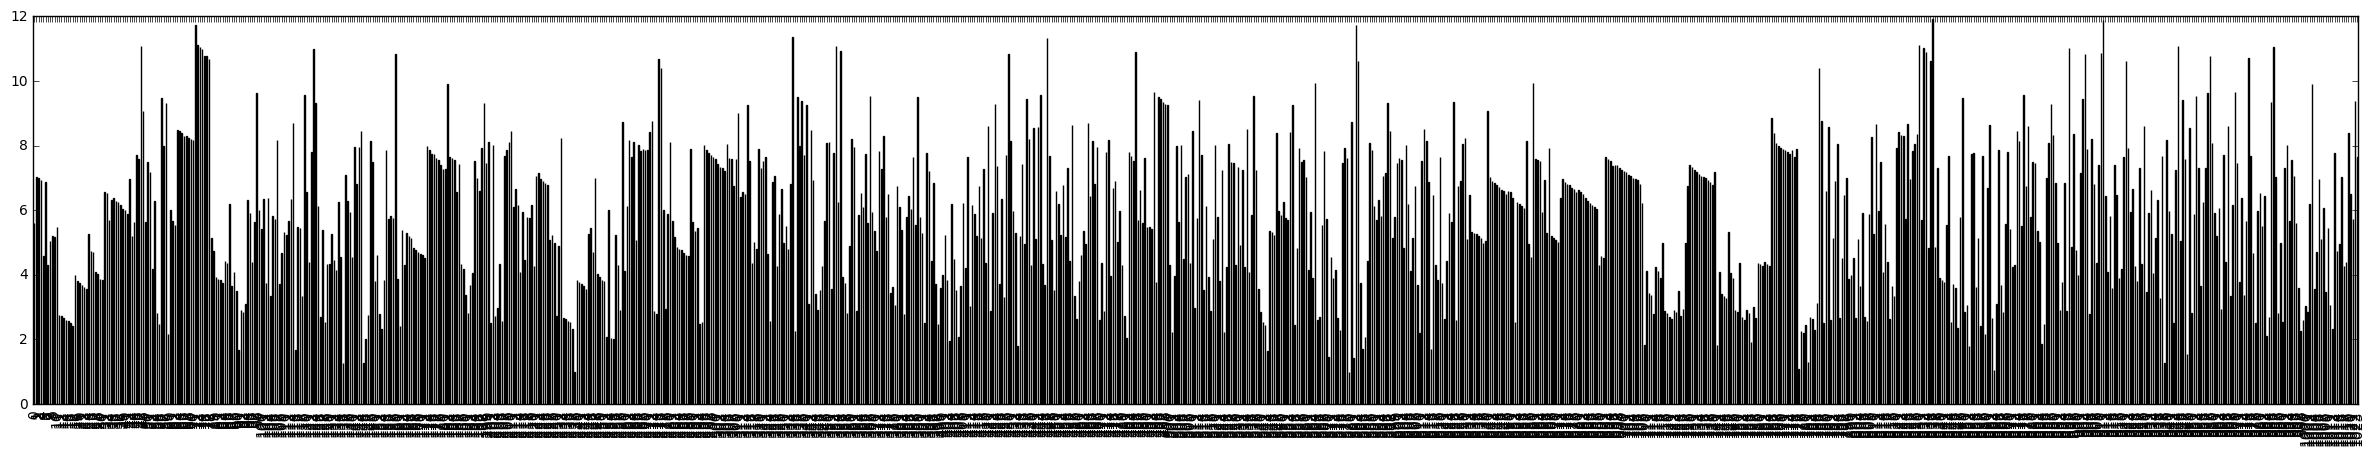

In [103]:
test = rpLF_emptyDB_131K_1024_1.drop(labels=['CU','Name','Scheduling','StagingInput','AgentStagingInputPending'],axis=1)

test['Done']                      = test['Done']                     -test['StagingOutput']
test['StagingOutput']             = test['StagingOutput']            -test['PendingOutputStaging']
test['PendingOutputStaging']      = test['PendingOutputStaging']     -test['AgentStagingOutput']
test['AgentStagingOutput']        = test['AgentStagingOutput']       -test['AgentStagingOutputPending']
test['AgentStagingOutputPending'] = test['AgentStagingOutputPending']-test['Executing']
test['Executing']                 = test['Executing']                -test['ExecutingPending']
test['ExecutingPending']          = test['ExecutingPending']         -test['Allocating']
test['Allocating']                = test['Allocating']               -test['AllocatingPending']
test['AllocatingPending']         = test['AllocatingPending']        -test['AgentStagingInput']

test[:-1]['AgentStagingOutputPending'].plot(kind='bar',stacked=True,figsize=(30,5),width=0.25)
plt.savefig('test3.pdf',bbox_inches='tight')

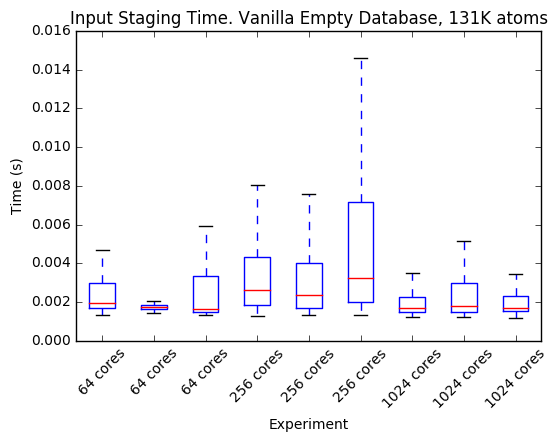

In [128]:
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([rpLF_emptyDB_131K_64_1[:-1]['AllocatingPending']   - rpLF_emptyDB_131K_64_1[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_64_2[:-1]['AllocatingPending']   - rpLF_emptyDB_131K_64_2[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_64_3[:-1]['AllocatingPending']   - rpLF_emptyDB_131K_64_3[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_256_1[:-1]['AllocatingPending']  - rpLF_emptyDB_131K_256_1[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_256_2[:-1]['AllocatingPending']  - rpLF_emptyDB_131K_256_2[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_256_3[:-1]['AllocatingPending']  - rpLF_emptyDB_131K_256_3[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_1024_1[:-1]['AllocatingPending'] - rpLF_emptyDB_131K_1024_1[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_1024_2[:-1]['AllocatingPending'] - rpLF_emptyDB_131K_1024_2[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_1024_3[:-1]['AllocatingPending'] - rpLF_emptyDB_131K_1024_3[:-1]['AgentStagingInput']], 
            meanline=True, showmeans=False, showcaps=True, 
            showbox=True, showfliers=False, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)

plt.title('Input Staging Time. Vanilla Empty Database, 131K atoms')
plt.savefig('InputStagingTimeVanillaEmptyDB.pdf',bbox_inches='tight')
plt.savefig('InputStagingTimeVanillaEmptyDB.png',bbox_inches='tight')

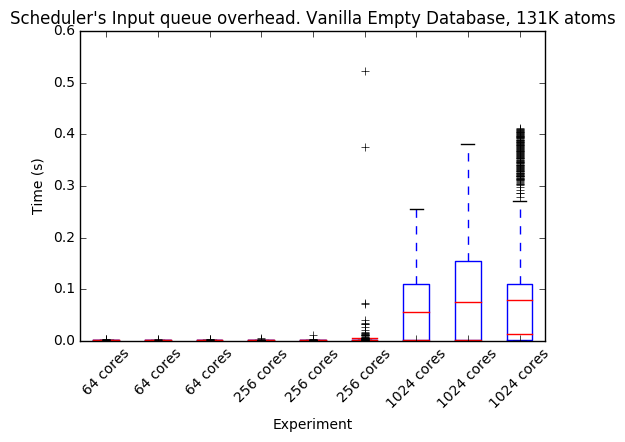

In [129]:
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([rpLF_emptyDB_131K_64_1[:-1]['Allocating']   - rpLF_emptyDB_131K_64_1[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_64_2[:-1]['Allocating']   - rpLF_emptyDB_131K_64_2[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_64_3[:-1]['Allocating']   - rpLF_emptyDB_131K_64_3[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_256_1[:-1]['Allocating']  - rpLF_emptyDB_131K_256_1[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_256_2[:-1]['Allocating']  - rpLF_emptyDB_131K_256_2[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_256_3[:-1]['Allocating']  - rpLF_emptyDB_131K_256_3[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_1024_1[:-1]['Allocating'] - rpLF_emptyDB_131K_1024_1[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_1024_2[:-1]['Allocating'] - rpLF_emptyDB_131K_1024_2[:-1]['AllocatingPending'],\
             rpLF_emptyDB_131K_1024_3[:-1]['Allocating'] - rpLF_emptyDB_131K_1024_3[:-1]['AllocatingPending']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)

plt.title("Scheduler's Input queue overhead. Vanilla Empty Database, 131K atoms")
plt.savefig('SchedulerInputQueueOverheadVanillaEmptyDB.pdf',bbox_inches='tight')
plt.savefig('SchedulerInputQueueOverheadVanillaEmptyDB.png',bbox_inches='tight')

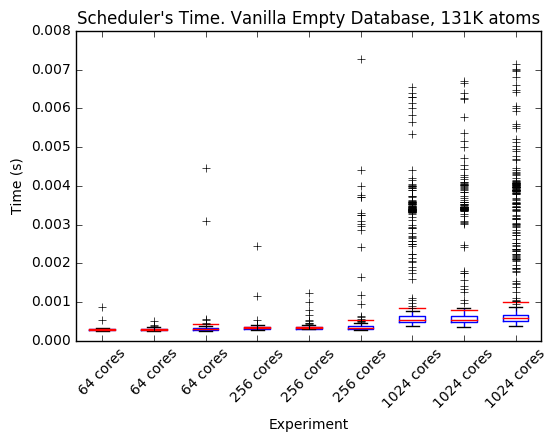

In [130]:
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([rpLF_emptyDB_131K_64_1[:-1]['ExecutingPending']   - rpLF_emptyDB_131K_64_1[:-1]['Allocating'],\
             rpLF_emptyDB_131K_64_2[:-1]['ExecutingPending']   - rpLF_emptyDB_131K_64_2[:-1]['Allocating'],\
             rpLF_emptyDB_131K_64_3[:-1]['ExecutingPending']   - rpLF_emptyDB_131K_64_3[:-1]['Allocating'],\
             rpLF_emptyDB_131K_256_1[:-1]['ExecutingPending']  - rpLF_emptyDB_131K_256_1[:-1]['Allocating'],\
             rpLF_emptyDB_131K_256_2[:-1]['ExecutingPending']  - rpLF_emptyDB_131K_256_2[:-1]['Allocating'],\
             rpLF_emptyDB_131K_256_3[:-1]['ExecutingPending']  - rpLF_emptyDB_131K_256_3[:-1]['Allocating'],\
             rpLF_emptyDB_131K_1024_1[:-1]['ExecutingPending'] - rpLF_emptyDB_131K_1024_1[:-1]['Allocating'],\
             rpLF_emptyDB_131K_1024_2[:-1]['ExecutingPending'] - rpLF_emptyDB_131K_1024_2[:-1]['Allocating'],\
             rpLF_emptyDB_131K_1024_3[:-1]['ExecutingPending'] - rpLF_emptyDB_131K_1024_3[:-1]['Allocating']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)

plt.title("Scheduler's Time. Vanilla Empty Database, 131K atoms")
plt.savefig('SchedulerITimeVanillaEmptyDB.pdf',bbox_inches='tight')
plt.savefig('SchedulerTimeVanillaEmptyDB.png',bbox_inches='tight')

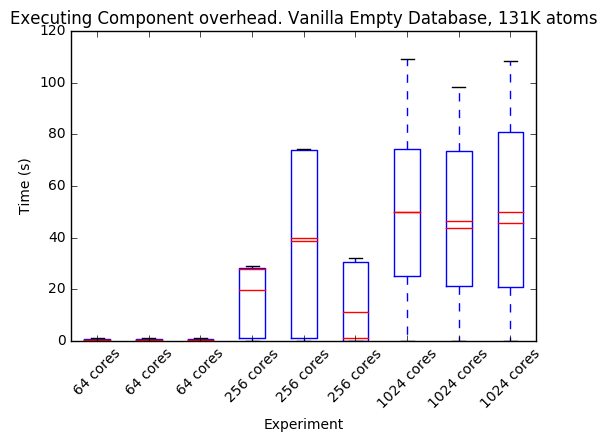

In [131]:
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([rpLF_emptyDB_131K_64_1[:-1]['Executing']   - rpLF_emptyDB_131K_64_1[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_64_2[:-1]['Executing']   - rpLF_emptyDB_131K_64_2[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_64_3[:-1]['Executing']   - rpLF_emptyDB_131K_64_3[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_256_1[:-1]['Executing']  - rpLF_emptyDB_131K_256_1[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_256_2[:-1]['Executing']  - rpLF_emptyDB_131K_256_2[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_256_3[:-1]['Executing']  - rpLF_emptyDB_131K_256_3[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_1024_1[:-1]['Executing'] - rpLF_emptyDB_131K_1024_1[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_1024_2[:-1]['Executing'] - rpLF_emptyDB_131K_1024_2[:-1]['ExecutingPending'],\
             rpLF_emptyDB_131K_1024_3[:-1]['Executing'] - rpLF_emptyDB_131K_1024_3[:-1]['ExecutingPending']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)

plt.title('Executing Component overhead. Vanilla Empty Database, 131K atoms')
plt.savefig('ExecutingComponentOverheadVanillaEmptyDB.pdf',bbox_inches='tight')
plt.savefig('ExecutingComponentOverheadVanillaEmptyDB.png',bbox_inches='tight')

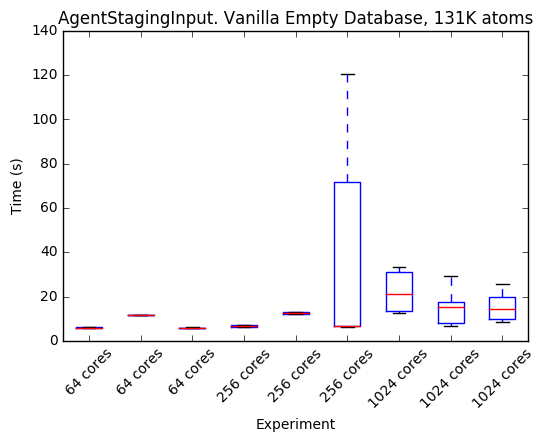

In [132]:
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([rpLF_emptyDB_131K_64_1[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_64_2[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_64_3[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_256_1[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_256_2[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_256_3[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_1024_1[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_1024_2[:-1]['AgentStagingInput'],\
             rpLF_emptyDB_131K_1024_3[:-1]['AgentStagingInput']], 
            meanline=True, showmeans=False, showcaps=True, 
            showbox=True, showfliers=False, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)

plt.title('AgentStagingInput. Vanilla Empty Database, 131K atoms')
plt.savefig('AgentStagingInputVanillaEmptyDB.pdf',bbox_inches='tight')
plt.savefig('AgentStagingInputVanillaEmptyDB.png',bbox_inches='tight')